# Load dataset

In [26]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # '2' hides INFO and WARNING messages

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [27]:
import idx2numpy

# Load training images and labels
train_images = idx2numpy.convert_from_file('dataset/train-images-idx3-ubyte')
train_labels = idx2numpy.convert_from_file('dataset/train-labels-idx1-ubyte')

# Load testing images and labels
test_images = idx2numpy.convert_from_file('dataset/t10k-images-idx3-ubyte')
test_labels = idx2numpy.convert_from_file('dataset/t10k-labels-idx1-ubyte')

# Preprocess images: normalize and reshape to (28,28,1)
x_train = train_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_train = train_labels
x_test = test_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_test = test_labels

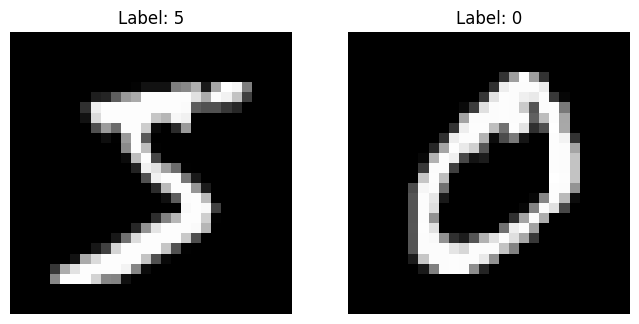

In [28]:
import matplotlib.pyplot as plt

# Plot the first two images from x_train with their corresponding labels from y_train
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    # Reshape the image to (28, 28) for display
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

# Building the model

In [30]:
import mlflow
import mlflow.tensorflow

hyperparams = {
    "dropout_rates": [0.3, 0.5],
    "learning_rates": [0.001, 0.0001]
}

best_accuracy = 0.0

# Grid search for hyperparameters
for dropout_rate in hyperparams["dropout_rates"]:
    for learning_rate in hyperparams["learning_rates"]:
        with mlflow.start_run():
            # Log hyperparameters
            mlflow.log_param("dropout_rate", dropout_rate)
            mlflow.log_param("learning_rate", learning_rate)

            # Train first model on training data
            model1 = create_model(dropout_rate, learning_rate)
            history1 = model1.fit(
                x_train, y_train,
                epochs=5,
                verbose=1
            )
            
            # Train second model on training data
            model2 = create_model(dropout_rate, learning_rate)
            history2 = model2.fit(
                x_train, y_train,
                epochs=5,
                verbose=1
            )
            
            # Evaluate ensemble model on test data
            ensemble_pred = ensemble_predictions(model1, model2, x_test)
            ensemble_accuracy = np.mean(np.argmax(ensemble_pred, axis=1) == y_test)
            
            mlflow.log_metric("ensemble_accuracy", ensemble_accuracy)
            
            # Optionally, log models
            mlflow.tensorflow.log_model(model1, "model1")
            mlflow.tensorflow.log_model(model2, "model2")
            
            print(f"Dropout: {dropout_rate}, LR: {learning_rate}, Ensemble Acc: {ensemble_accuracy:.4f}")

            # Save the best-performing models
            if ensemble_accuracy > best_accuracy:
                best_accuracy = ensemble_accuracy
                model1.save("model1_best.h5")
                model2.save("model2_best.h5")
                print(f"--> New best models saved with accuracy: {best_accuracy:.4f}")

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1619 - accuracy: 0.9496
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0587 - accuracy: 0.9817
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0426 - accuracy: 0.9869
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0319 - accuracy: 0.9904
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0281 - accuracy: 0.9914
Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1699 - accuracy: 0.9470
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0608 - accuracy: 0.9819
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0450 - accuracy: 0.9868
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0343 - accuracy: 0.9894
Epoch 5/5
313/313 [==============================] - 0s 1ms/step


2025/02/24 16:10:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmpzgk0p7n5/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmpzgk0p7n5/model/data/model/assets
2025/02/24 16:10:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/24 16:10:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmp7jnfuje8/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmp7jnfuje8/model/data/model/assets
2025/02/24 16:10:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dropout: 0.3, LR: 0.001, Ensemble Acc: 0.9930
--> New best models saved with accuracy: 0.9930
Epoch 1/5
   1/1875 [..............................] - ETA: 3:19 - loss: 2.3145 - accuracy: 0.0312

/opt/anaconda3/envs/mlops/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 8s 4ms/step - loss: 0.4217 - accuracy: 0.8799
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1302 - accuracy: 0.9610
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0941 - accuracy: 0.9714
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0761 - accuracy: 0.9770
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0632 - accuracy: 0.9810
Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4403 - accuracy: 0.8741
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1361 - accuracy: 0.9588
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0992 - accuracy: 0.9701
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0819 - accuracy: 0.9751
Epoch 5/5
313/313 [==============================] - 0s 1ms/step


2025/02/24 16:12:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmp7_y6uvw2/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmp7_y6uvw2/model/data/model/assets
2025/02/24 16:12:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/24 16:12:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmpdc2gnlj8/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmpdc2gnlj8/model/data/model/assets
2025/02/24 16:12:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dropout: 0.3, LR: 0.0001, Ensemble Acc: 0.9870
Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2023 - accuracy: 0.9385
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0784 - accuracy: 0.9776
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0582 - accuracy: 0.9835
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0455 - accuracy: 0.9864
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0362 - accuracy: 0.9891
Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2075 - accuracy: 0.9366
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0767 - accuracy: 0.9778
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0573 - accuracy: 0.9833
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0455 - accuracy: 0.9861
Epoch 5/5
313/313 [=========================

2025/02/24 16:13:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmp0tu9nbjw/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmp0tu9nbjw/model/data/model/assets
2025/02/24 16:13:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/24 16:13:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmp7yzeleg7/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmp7yzeleg7/model/data/model/assets
2025/02/24 16:13:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dropout: 0.5, LR: 0.001, Ensemble Acc: 0.9936
--> New best models saved with accuracy: 0.9936
Epoch 1/5
   1/1875 [..............................] - ETA: 3:17 - loss: 2.3511 - accuracy: 0.0625

/opt/anaconda3/envs/mlops/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 8s 4ms/step - loss: 0.5350 - accuracy: 0.8408
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1742 - accuracy: 0.9490
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1286 - accuracy: 0.9616
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1035 - accuracy: 0.9692
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0888 - accuracy: 0.9737
Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5361 - accuracy: 0.8410
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1727 - accuracy: 0.9495
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1257 - accuracy: 0.9626
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1017 - accuracy: 0.9695
Epoch 5/5
313/313 [==============================] - 0s 1ms/step


2025/02/24 16:15:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmpo2wi3tep/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmpo2wi3tep/model/data/model/assets
2025/02/24 16:15:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/24 16:15:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmpl7h86ldn/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/p_/h13vrd1n5rx9gydc1ms4yj6c0000gn/T/tmpl7h86ldn/model/data/model/assets
2025/02/24 16:15:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dropout: 0.5, LR: 0.0001, Ensemble Acc: 0.9857
